In [2]:
using OptimalTransport
using VegaLite
using MLDatasets
using Distances
using Distributions
using Images
using DataFrames
using LinearAlgebra
using SparseArrays
using Tulip
using UMAP

In [3]:
# EMNIST.Digits.traindata()

## Importing and reshaping datasets

In [13]:
mnist_x = reshape(MNIST.traintensor(Float64),28*28,:);
mnist_y = MNIST.trainlabels(1:size(mnist_x, 2));
fmnist_x = reshape(FashionMNIST.traintensor(Float64),28*28,:);
fmnist_y = FashionMNIST.trainlabels(1:size(fmnist_x, 2));

N = 1000
mnist_x  = mnist_x'[1:N,:]
mnist_y  = mnist_y[1:N]
fmnist_x = fmnist_x'[1:N,:]
fmnist_y = fmnist_y[1:N];

In [10]:
"""
    _fit_MvNormals(X,y)
`X` is the feature dataset, where rows are the samples and the columns
are feateus. Vector `y` is the label vector.
"""
function _fit_MvNormals(X,y)
    labels = sort(unique(y))
    α = []
    for i in labels
        Σ = cov(X[y .== i,:]);
        Σ += max(0,-2*eigmin(Σ))*I
        m = vec(mean(X[y .== i, :],dims=1))
        push!(α, MvNormal(m,Σ))
    end
    return α
end

function _getW(X1, y1, X2, y2)
    α1 = _fit_MvNormals(X1, y1)
    α2 = _fit_MvNormals(X2, y2)
    
    Wα = zeros(length(α1),length(α2))
    for (i,j) in Iterators.product(1:length(α1),1:length(α2))
        Wα[i,j] = ot_cost(SqEuclidean(), α1[i],α2[j])
    end
    return Wα
end

"""
    otdd(dx, D1, D2, ε = 0.1)
Calculates the Optimal Transport Dataset Distance between
datasets D1 and D2, using metric dx between features
distance. Note that `dx` must be a `PreMetric` from `Distances.jl`.
"""
function otdd(X1, y1, X2, y2; ε = 1, dx=SqEuclidean(), W = nothing)
    if W == nothing
        α1 = _fit_MvNormals(X1, y1)
        α2 = _fit_MvNormals(X2, y2)

        # store the 2-Wasserstein distance
        # between P(X1 | y1 = i) and P(X2 | y2 = j)
        W = zeros(length(α1),length(α2))
        for (i,j) in Iterators.product(1:length(α1),1:length(α2))
            W[i,j] = ot_cost(SqEuclidean(), α1[i],α2[j])
        end
    end
    
    C = pairwise(dx, X1, X2, dims=1);
    for (i,j) in Iterators.product(1:N,1:N)
        C[i,j] = sqrt(C[i,j] + W[y1[i]+1,y2[j]+1])
    end
    
    n1 = length(y1)
    n2 = length(y2)
    γ = sinkhorn(ones(n1)./n1, ones(n2)./n2, C, ε);
    
    return C, γ, dot(C,γ)
end

otdd

In [7]:
Wα = _getW(mnist_x, mnist_y, fmnist_x, fmnist_y);

In [14]:
C, γ, cost = otdd(mnist_x, mnist_y, fmnist_x, fmnist_y, W = Wα);

In [8]:
N = 100
res_jl = umap(hcat(mnist_x[:,1:N],fmnist_x[:,1:N]); n_neighbors=10, min_dist=0.001, n_epochs=200);

In [9]:
df = DataFrame(
    x1     = res_jl'[:,1],
    x2     = res_jl'[:,2],
    label  = vcat(mnist_y[1:N],fmnist_y[1:N]),
    dataset= vcat(["mnist" for i in 1:N],["fmnist" for i in 1:N]));

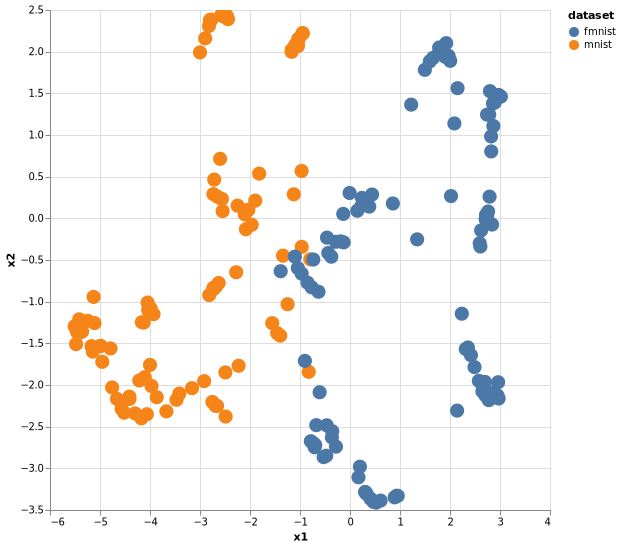

In [10]:
p1 =@vlplot("data"=df,
    mark={"type"=:circle,"size"=200,"opacity"=1},
    selection={"grid"={
    "type"=:interval,
    "resolve"=:global,
    "bind"=:scales,
    "translate"="[mousedown[!event.shiftKey], window:mouseup] > window:mousemove!",
                "zoom"="wheel![!event.shiftKey]"}},
    x={:x1,"type"="quantitative"},
    y={:x2,"type"="quantitative"},
    color={:dataset, "type"="nominal"},"height"=500,"width"=500)